### CSV test

In [1]:
import pandas as pd
bird_results = pd.read_csv('logs_merged.csv')
bird_results.head(10)


Unnamed: 0                                           question  \
0           0  What is the highest eligible free rate for K-1...   
1           1  Please list the lowest three eligible free rat...   
2           2  Please list the zip code of all the charter sc...   
3           0               Give the number of "Revival" badges.   
4           1  What is the title for the post which got the h...   
5           2  For the post which got 1910 view counts, how m...   
6           3  User No.3025 gave a comment at 20:29:39 on 201...   
7           4  Give the only one comment text of the post wit...   
8           5  User No.23853 gave a comment to a post at 9:08...   
9           6  For the owner user of post No. 65041, what is ...   

                                          gold_query               db_id  \
0  SELECT `FRPM Count (K-12)` / `Enrollment (K-12...  california_schools   
1  SELECT `Free Meal Count (Ages 5-17)` / `Enroll...  california_schools   
2  SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...  california_schools   
3  SELECT COUNT(Id) FROM badges WHERE Name = 'Rev...  codebase_community   
4  SELECT Title FROM posts WHERE Id = ( SELECT Po...  codebase_community   
5  SELECT COUNT(T1.Id) FROM posts AS T1 INNER JOI...  codebase_community   
6  SELECT T1.FavoriteCount FROM posts AS T1 INNER...  codebase_community   
7  SELECT T2.Text FROM posts AS T1 INNER JOIN com...  codebase_community   
8  SELECT IIF(T2.ClosedDate IS NULL, 'NOT well-fi...  codebase_community   
9  SELECT T1.Reputation FROM users AS T1 INNER JO...  codebase_community   

                                         final_query  \
0  SELECT frpm."FRPM Count (K-12)" / frpm."Enroll...   
1  SELECT frpm."Free Meal Count (Ages 5-17)" / fr...   
2  SELECT schools.Zip FROM schools INNER JOIN frp...   
3  SELECT COUNT(*) FROM badges WHERE Name = 'Revi...   
4  SELECT posts.Title FROM posts INNER JOIN comme...   
5  SELECT COUNT(*) FROM posts INNER JOIN comments...   
6  SELECT T3.FavoriteCount FROM users AS T1 INNER...   
7  SELECT comments.Text FROM comments INNER JOIN ...   
8  SELECT CASE WHEN T3.ClosedDate IS NULL THEN 'N...   
9  SELECT users.Reputation FROM posts INNER JOIN ...   

                                      schema_linking  \
0  "highest eligible free rate" so we need column...   
1  "lowest three eligible free rates" so we need ...   
2  "zip code" so we need column = [schools.Zip]\n...   
3  "number" so we need column = [badges.Id]\n"Rev...   
4  "the title for the post" so we need column = [...   
5  "post" so we need column = [posts.Id]\n"view c...   
6  "User No.3025" so we need column = [users.Id]\...   
7  "comment text" so we need column = [comments.T...   
8  "User No.23853" so we need column = [users.Id]...   
9  "owner user" so we need column = [posts.OwnerU...   

                                      classification  \
0  The SQL query for the given question needs the...   
1  The SQL query for the given question needs the...   
2  The SQL query for the given question needs the...   
3  The SQL query for the given question needs the...   
4  The SQL query for the given question needs the...   
5  The SQL query for the given question needs the...   
6  The SQL query for the given question needs the...   
7  The SQL query for the given question needs the...   
8  The SQL query for the given question needs the...   
9  The SQL query for the given question needs the...   

                                      sql_generation  \
0  For creating the SQL for the given question, w...   
1  For creating the SQL for the given question, w...   
2  For creating the SQL for the given question, w...   
3  SELECT COUNT(*) FROM badges WHERE Name = 'Revi...   
4  For creating the SQL for the given question, w...   
5  For creating the SQL for the given question, w...   
6  For creating the SQL for the given question, w...   
7  For creating the SQL for the given question, w...   
8  For creating the SQL for the given question, w...   
9  For

In [2]:
bird_results.size

12726

### Plots

In [15]:
data ={
    'Name': ['Zero-Shot (GPT-3.5)','Few-Shot (GPT-3.5)','DIN-SQL (GPT-3.5)',"Zero-Shot (GPT-4)"],
    'Iteration 1': [37.14, 36.19, 40.57, 38.09],
    'Iteration 2': [45.28, 50, 50.94, 55.66]
}
df = pd.DataFrame(data)


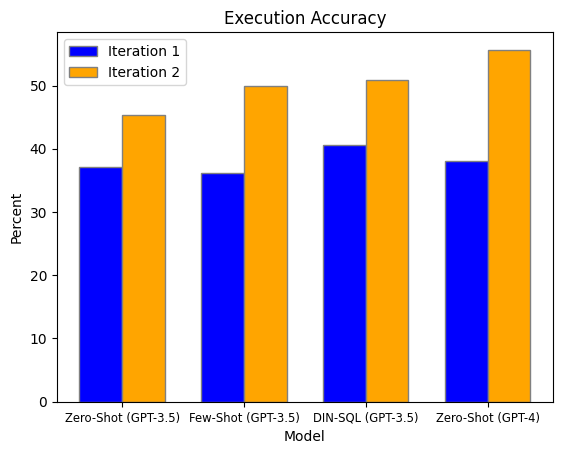

In [16]:
import matplotlib.pyplot as plt
import numpy as np
 
# Set the width of the bars
barWidth = 0.35


# Set position of bar on X axis
r1 = np.arange(len(df['Iteration 1']))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, df['Iteration 1'], color='b', width=barWidth, edgecolor='grey', label='Iteration 1')
plt.bar(r2, df['Iteration 2'], color='orange', width=barWidth, edgecolor='grey', label='Iteration 2')

# Add xticks on the middle of the group bars
plt.xlabel('Model')
plt.xticks([r + barWidth/2 for r in range(len(df['Iteration 1']))], df['Name'], fontsize='small')

#y-axis
plt.ylabel('Percent')
# Create legend & Show graphic
plt.legend()
plt.title('Execution Accuracy')
plt.show()


In [1]:
import sqlite3
import os
from collections import Counter

class DatabaseInterface():

    DEV_DB_PATH = os.path.abspath(
      os.path.join(os.getcwd(), '..', 'data/BIRD/dev/dev_databases/'))
   
    TRAIN_DB_PATH = os.path.abspath(
      os.path.join(os.getcwd(), '..', 'data/BIRD/train/train_databases/'))

    def __init__(self):
      self.conn = None
      self.cursor = None
      self.data = []

      self.current_db = ""
      self.current_database_schema = ""

      self.load_database_names()


    def execute_queries_and_match_data(self, sql: str, gold_sql: str, db_name: str) -> int:
        """
        Execute provided SQL queries and compare the results.

        Parameters:
            sql (str): The predicted SQL query to execute.
            gold_sql (str): The golden SQL query to compare results.
            db_name (str): The database name on which the queries will be executed.

        Returns:
            int: 1 if the results match, otherwise 0.
        """

        if self.current_db != db_name:
            self.load_db(db_name)
        
        try:            
            self.cursor.execute(sql)
            pred_res = self.cursor.fetchall()                
        except sqlite3.Error as err:            
            return 0

        try:
          self.cursor.execute(gold_sql)
          golden_res = self.cursor.fetchall()
        except sqlite3.Error as err:            
          return 0

        equal = (Counter(pred_res) == Counter(golden_res))
        return int(equal)
    
    def load_db(self, db_name: str) -> None:
      """
      Load a database into the class by connecting and setting a cursor.

      Parameters:
         db_name (str): The name of the database to load.
      """
      db_path = ""
      if db_name in self.dev_databases:
         db_path = f"{self.DEV_DB_PATH}/{db_name}/{db_name}.sqlite"
      else:
         db_path = f"{self.TRAIN_DB_PATH}/{db_name}/{db_name}.sqlite"
         
      self.conn = sqlite3.connect(db_path)      
      self.cursor = self.conn.cursor()
      self.current_db = db_name

    
    def load_database_names(self):
      self.dev_databases = os.listdir(self.DEV_DB_PATH)
      self.train_databases = os.listdir(self.TRAIN_DB_PATH)
   

In [28]:
import pandas as pd


df = pd.read_csv('logs_merged.csv')
db = DatabaseInterface()

total_successes = 0
total_successes_per_domain = {}
total_questions_per_domain = {}

for index, row in df.iterrows():
    
    gold_query = row['gold_query']
    predicted_query = row['final_query']
    db_id = row['db_id']

    success = db.execute_queries_and_match_data(predicted_query, gold_query, db_id)
    total_successes += success

    if not db_id in total_successes_per_domain:
        total_successes_per_domain[db_id] = success
    else:
        total_successes_per_domain[db_id] += success

    if not db_id in total_questions_per_domain:
        total_questions_per_domain[db_id] = 1
    else:
        total_questions_per_domain[db_id] += 1

    if index % 100 == 0:
        print("At row: " + str(index) + " Total successes: " + str(total_successes))



At row: 0 Total successes: 0
At row: 100 Total successes: 53
At row: 200 Total successes: 117
At row: 300 Total successes: 172
At row: 400 Total successes: 205
At row: 500 Total successes: 232
At row: 600 Total successes: 268
At row: 700 Total successes: 285
At row: 800 Total successes: 318
At row: 900 Total successes: 354
At row: 1000 Total successes: 381
At row: 1100 Total successes: 413
At row: 1200 Total successes: 443
At row: 1300 Total successes: 475
At row: 1400 Total successes: 517


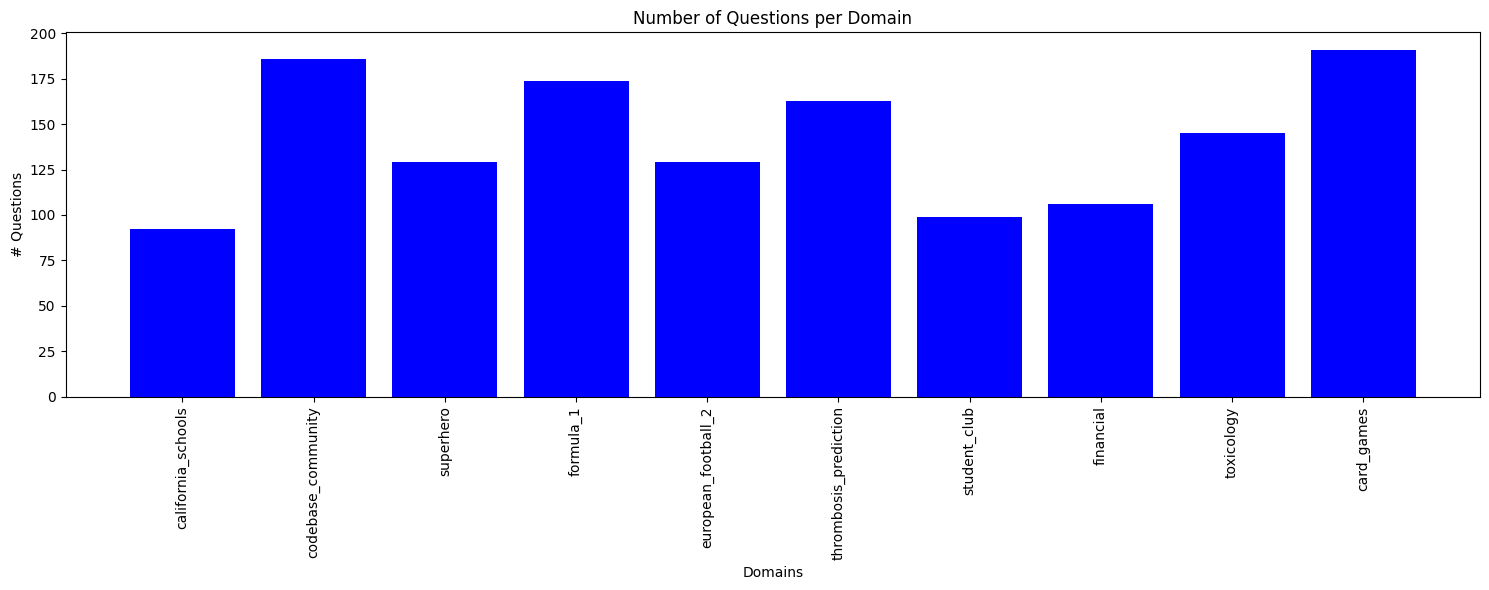

In [43]:
import matplotlib.pyplot as plt

# Creating a bar plot
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(total_questions_per_domain.keys(), total_questions_per_domain.values(), color='blue')
plt.xlabel('Domains')
plt.ylabel('# Questions')
plt.title('Number of Questions per Domain')
plt.xticks(rotation=90)  # Rotate the domain names for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely

plt.show()

In [37]:
for key in total_questions_per_domain:
    print(key + ": " + str(total_questions_per_domain[key]))

california_schools: 92
codebase_community: 186
superhero: 129
formula_1: 174
european_football_2: 129
thrombosis_prediction: 163
student_club: 99
financial: 106
toxicology: 145
card_games: 191


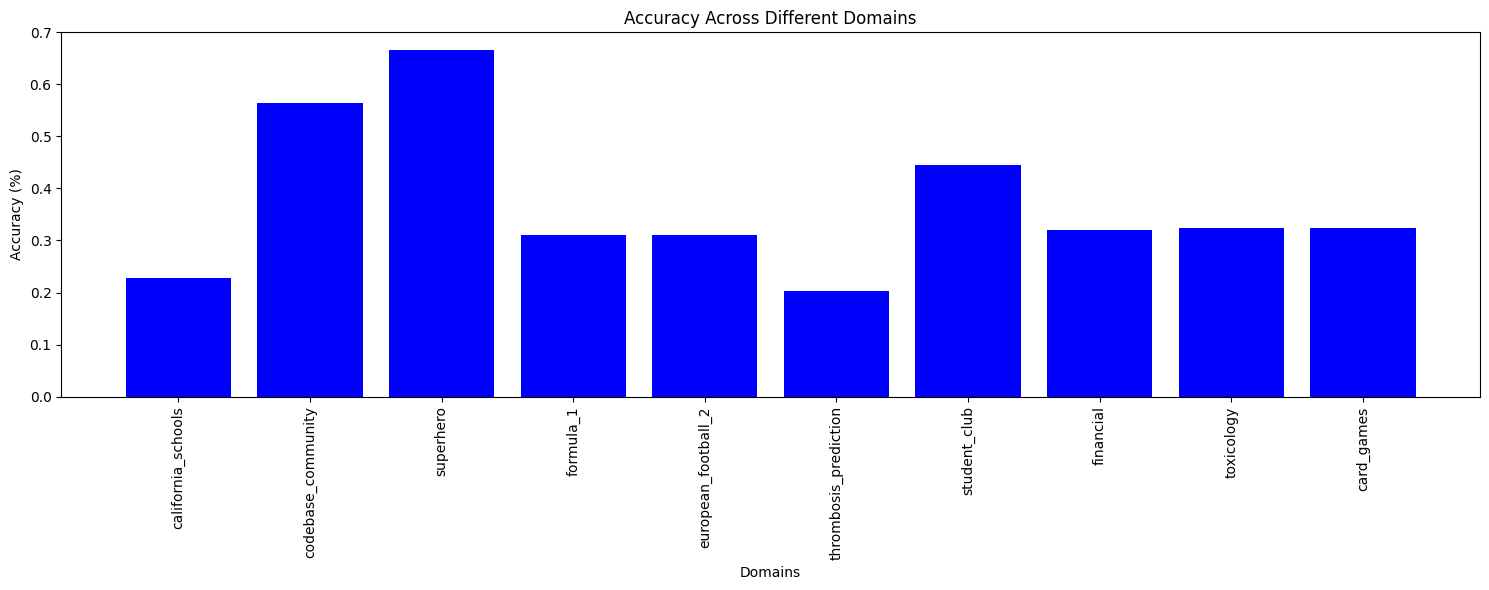

In [35]:
import matplotlib.pyplot as plt


accuracies = [x/y for x,y in zip(total_successes_per_domain.values(), total_questions_per_domain.values())]

# Creating a bar plot
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
plt.bar(total_questions_per_domain.keys(), accuracies, color='blue')
plt.xlabel('Domains')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Across Different Domains')
plt.xticks(rotation=90)  # Rotate the domain names for better readability
plt.tight_layout()  # Adjust layout to fit everything nicely

plt.show()

In [46]:
domain_accuracies = zip(total_questions_per_domain.keys(), accuracies)

for key in domain_accuracies:    
    print(key[0] + ": " + str(key[1]))

california_schools: 0.22826086956521738
codebase_community: 0.5645161290322581
superhero: 0.6666666666666666
formula_1: 0.3103448275862069
european_football_2: 0.31007751937984496
thrombosis_prediction: 0.20245398773006135
student_club: 0.4444444444444444
financial: 0.32075471698113206
toxicology: 0.32413793103448274
card_games: 0.32460732984293195


In [58]:
domain_accuracies = zip(total_questions_per_domain.keys(), accuracies)
total_acc = 0
for domain in domain_accuracies:
    total_acc += domain[1]


print("Mean accuracy: " + str(total_acc / len(total_questions_per_domain.values())))
print("Finance domain: 0.32075471698113206")

Mean accuracy: 0.3696264422263247
Finance domain: 0.32075471698113206


In [13]:
# Dev DB path
DEV_DB_PATH = os.path.abspath(
      os.path.join(os.getcwd(), '..', 'data/BIRD/dev/dev_databases/'))

# Function to get the schema of a database
databases = ["california_schools", "codebase_community", "superhero", "formula_1", "european_football_2", "thrombosis_prediction", "student_club", "financial", "toxicology", "card_games"]

# Function to get the schema and statistics of a database
def get_db_stats(db_file):
    db_path = os.path.join(DEV_DB_PATH, db_file, db_file + ".sqlite")
    
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()

        # Get all tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        # Dictionary to store stats
        stats = {'tables': len(tables), 'total_columns': 0, 'columns_per_table': {}}

        for table in tables:
            table_name = table[0]
            cursor.execute(f"PRAGMA table_info(\"{table_name}\");")
            columns = cursor.fetchall()

            # Update stats
            num_columns = len(columns)            
            
            stats['total_columns'] += num_columns
            stats['columns_per_table'][table_name] = num_columns

        return stats

# Analyzing each database and storing statistics
db_stats = {}
for db in databases:
    stats = get_db_stats(db)
    db_stats[db] = stats

# Print the statistics for each database
for db, stats in db_stats.items():
    print(f"Database: {db}")
    print(f"  Number of Tables: {stats['tables']}")
    print(f"  Total Number of Columns: {stats['total_columns']}")
    for table, num_columns in stats['columns_per_table'].items():
        print(f"  Table '{table}' has {num_columns} columns")
    print("\n")


Database: california_schools
  Number of Tables: 3
  Total Number of Columns: 89
  Table 'frpm' has 29 columns
  Table 'satscores' has 11 columns
  Table 'schools' has 49 columns


Database: codebase_community
  Number of Tables: 8
  Total Number of Columns: 71
  Table 'badges' has 4 columns
  Table 'comments' has 7 columns
  Table 'postHistory' has 9 columns
  Table 'postLinks' has 5 columns
  Table 'posts' has 21 columns
  Table 'tags' has 5 columns
  Table 'users' has 14 columns
  Table 'votes' has 6 columns


Database: superhero
  Number of Tables: 10
  Total Number of Columns: 31
  Table 'alignment' has 2 columns
  Table 'attribute' has 2 columns
  Table 'colour' has 2 columns
  Table 'gender' has 2 columns
  Table 'publisher' has 2 columns
  Table 'race' has 2 columns
  Table 'superhero' has 12 columns
  Table 'hero_attribute' has 3 columns
  Table 'superpower' has 2 columns
  Table 'hero_power' has 2 columns


Database: formula_1
  Number of Tables: 14
  Total Number of Columns:

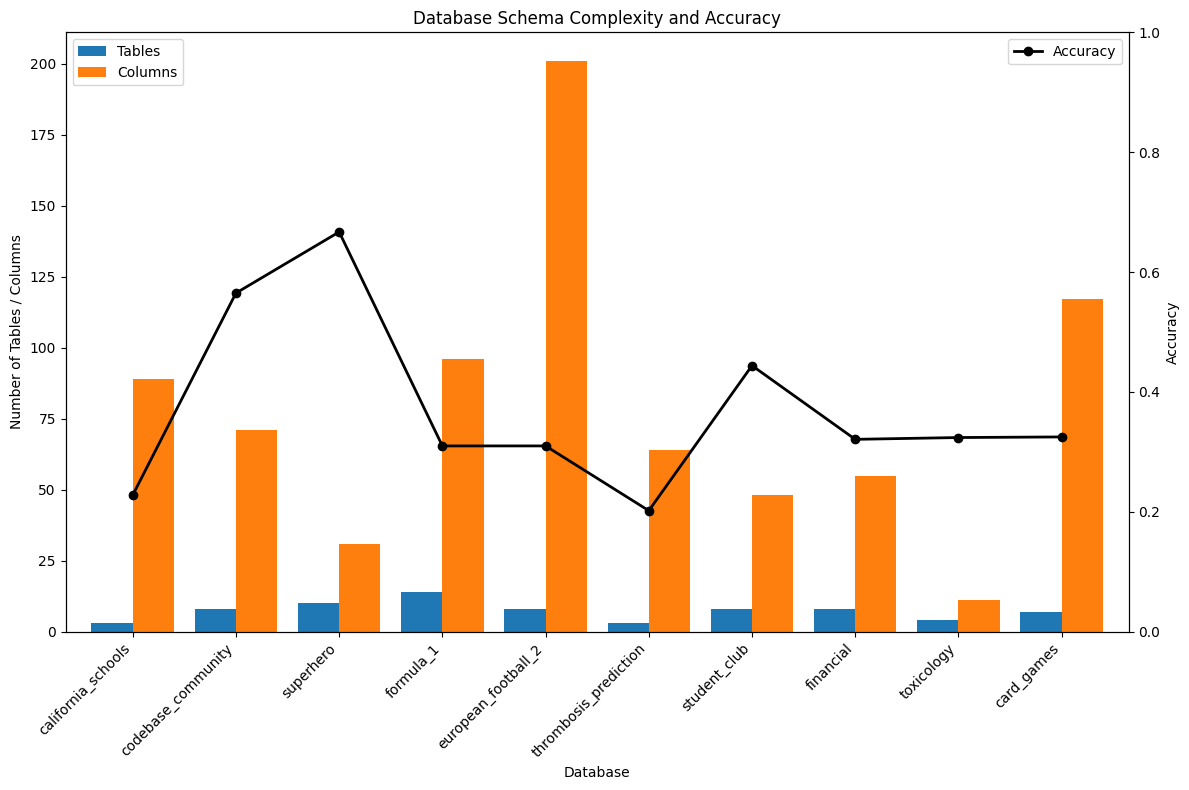

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Database information
data = {
    "Database": ["california_schools", "codebase_community", "superhero", "formula_1", 
                 "european_football_2", "thrombosis_prediction", "student_club", 
                 "financial", "toxicology", "card_games"],
    "Tables": [3, 8, 10, 14, 8, 3, 8, 8, 4, 7],
    "Columns": [89, 71, 31, 96, 201, 64, 48, 55, 11, 117],
    "Accuracy": [0.228, 0.565, 0.667, 0.310, 0.310, 0.202, 0.444, 0.321, 0.324, 0.325]
}

df = pd.DataFrame(data)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 8))

colors = ['blue' if db != 'financial' else 'red' for db in df['Database']]

# Bar plot for Tables and Columns
df.plot(kind='bar', x='Database', y=['Tables', 'Columns'], ax=ax1, width=0.8)
ax1.set_ylabel('Number of Tables / Columns')

# Line plot for Accuracy
ax2 = ax1.twinx()
df.plot(kind='line', x='Database', y='Accuracy', ax=ax2, color='k', marker='o', linewidth=2, label='Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)  # Accuracy ranges from 0 to 1

# Titles and labels
plt.title('Database Schema Complexity and Accuracy')
ax1.set_xlabel('Database')
ax1.set_xticklabels(df['Database'], rotation=45, ha='right')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.tight_layout()
plt.show()


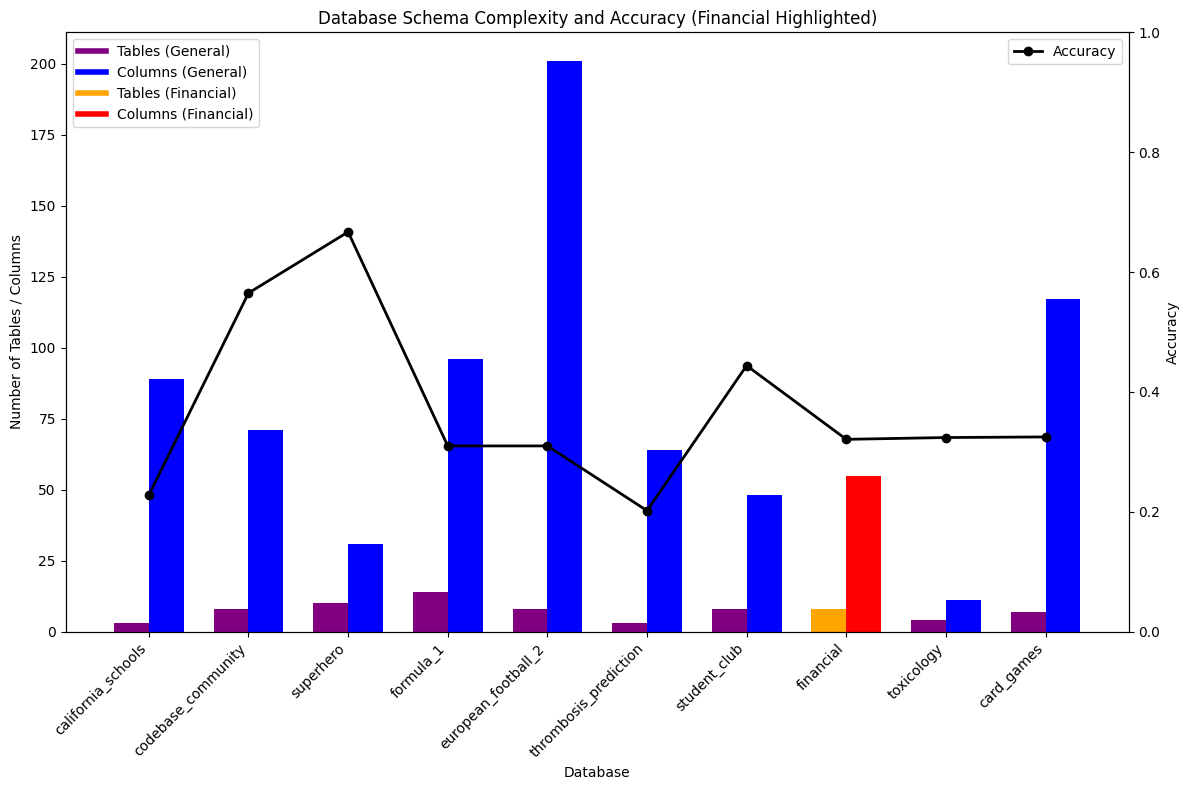

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

# Database information
data = {
    "Database": ["california_schools", "codebase_community", "superhero", "formula_1", 
                 "european_football_2", "thrombosis_prediction", "student_club", 
                 "financial", "toxicology", "card_games"],
    "Tables": [3, 8, 10, 14, 8, 3, 8, 8, 4, 7],
    "Columns": [89, 71, 31, 96, 201, 64, 48, 55, 11, 117],
    "Accuracy": [0.228, 0.565, 0.667, 0.310, 0.310, 0.202, 0.444, 0.321, 0.324, 0.325]
}

df = pd.DataFrame(data)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(12, 8))

# Number of databases
n_databases = len(df['Database'])

# Generate bar positions
bar_width = 0.35
index = np.arange(n_databases)

# Colors for Tables and Columns bars
table_colors = ['purple' if db != 'financial' else 'orange' for db in df['Database']]
column_colors = ['blue' if db != 'financial' else 'red' for db in df['Database']]

# Bar plot for Tables and Columns
tables_bars = ax1.bar(index - bar_width/2, df['Tables'], bar_width, label='Tables', color=table_colors)
columns_bars = ax1.bar(index + bar_width/2, df['Columns'], bar_width, label='Columns', color=column_colors)

ax1.set_ylabel('Number of Tables / Columns')
ax1.set_xticks(index)
ax1.set_xticklabels(df['Database'])
ax1.legend(loc='upper left')

# Line plot for Accuracy
ax2 = ax1.twinx()
df.plot(kind='line', x='Database', y='Accuracy', ax=ax2, color='k', marker='o', linewidth=2, label='Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)  # Accuracy ranges from 0 to 1
ax2.legend(loc='upper right')

# Titles and labels
plt.title('Database Schema Complexity and Accuracy (Financial Highlighted)')
ax1.set_xlabel('Database')
ax1.set_xticklabels(df['Database'], rotation=45, ha='right')

# Custom legend entries
legend_elements = [Line2D([0], [0], color='purple', lw=4, label='Tables (General)'),
                   Line2D([0], [0], color='blue', lw=4, label='Columns (General)'),
                   Line2D([0], [0], color='orange', lw=4, label='Tables (Financial)'),
                   Line2D([0], [0], color='red', lw=4, label='Columns (Financial)')]
ax1.legend(handles=legend_elements, loc='upper left')


# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import json
path = os.path.abspath(
      os.path.join(os.path.dirname( __file__ ), '..', 'data/BIRD/dev/financial_fixed.json'))

with open(path, 'r') as j:
      data = json.loads(j.read())


difficulties = {}
for data_point in data:
    if not data_point['difficulty'] in difficulties:
        difficulties[data_point['difficulty']] = 1
    elif data_point['difficulty'] in difficulties:
        difficulties[data_point['difficulty']] += 1